In [50]:
import pickle
from collections import namedtuple
import pandas as pd
import numpy as np
from importlib import reload
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import datetime

# bench_util module is in the parent directory, because it will be part of
# the production code.  Add the parent directory to the Path so Python can
# import from there
sys.path.insert(0, '../')   
import bench_util as bu
import graph_util as gu

## Unpickle the Dataframe for Preprocessed Utility Data & Make Utility Function Object

In [51]:
# Unpickle the pre-processed DataFrame
df = pickle.load(open('dfu3.pkl', 'rb'))

# Unpickle the raw utility bill DataFrame, which is needed below to make
# the utility function object.
df_raw = pickle.load(open('df_raw.pkl', 'rb'))

df.head()  # the processed data

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2010,7,Electricity charge,-,24.137931,35.0,0.000000,2011,1,0.000000
1,03,Electricity,2010,7,Electricity charge,kWh,1304.274655,9.5,6656.551724,2011,1,22.712154
2,03,Electricity,2010,8,Electricity charge,-,39.498433,62.0,0.000000,2011,2,0.000000
3,03,Electricity,2010,8,Electricity charge,kWh,4940.646254,31.0,26822.236155,2011,2,91.517470
4,03,Electricity,2010,9,Electricity charge,-,16.363636,27.0,0.000000,2011,3,0.000000


In [148]:
# Checking fiscal / calendar year for graph question.
year_2017 = df.query("fiscal_year == 2017")
site_2017 = year_2017.query("site_id == 'DIPMP1'")
year_2017.query("fiscal_mo == 10")

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
20370,ASLGDM,Oil #1,2017,4,Fuel Oil #1 (Gallons),-,143.881531,4.5,0.000000,2017,10,0.000000
20371,ASLGDM,Oil #1,2017,4,Other Charge,-,1.001939,4.5,NaN,2017,10,NaN
28157,DIPMP1,Electricity,2017,4,Demand Charge,kW,1781.538387,13.5,124.679032,2017,10,0.000000
28158,DIPMP1,Electricity,2017,4,Other Charge,-,6123.822097,13.5,NaN,2017,10,NaN
28159,DIPMP1,Electricity,2017,4,Utility Charge,kWh,3438.175645,13.5,54958.064516,2017,10,187.516916
30057,GSWNP,Electricity,2017,4,Other Charge,-,114.815909,10.5,NaN,2017,10,NaN
30058,GSWNP,Electricity,2017,4,Utility Charge,kWh,114.440455,10.5,992.727273,2017,10,3.387185
31462,HSPSWP,Electricity,2017,4,Demand Charge,kW,572.395645,13.5,40.064516,2017,10,0.000000
31463,HSPSWP,Electricity,2017,4,Other Charge,-,2584.936452,13.5,NaN,2017,10,NaN
31464,HSPSWP,Electricity,2017,4,Utility Charge,kWh,1472.802097,13.5,23542.258065,2017,10,80.326185


In [53]:
# this is only needed to update any code changes I may have made
# since last importing the module above.
reload(bu) 
reload(gu)

# Make an object that has the various utility functions.
# The object needs access to the raw utility bill DataFrame and the spreadsheet
# containing other application data.
ut = bu.Util(df_raw, '../data/Other_Building_Data.xlsx')

In [54]:
# Testing site.  Final code will loop through all sites
site = 'DIPMP1'

# Energy Use Overview Report - Page 4


In [55]:
# From the main DataFrame, get only the rows for this site, and only get
# the needed columns for this analysis
usage_df1 = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'mmbtu']]
usage_df1.head()

,service_type,fiscal_year,fiscal_mo,mmbtu
27864,Electricity,2011,1,232.491327
27865,Electricity,2011,1,0.000000
27866,Electricity,2011,1,0.000000
27867,Electricity,2011,1,NaN
27868,Electricity,2011,2,423.797568


In [56]:
usage_df1.query("service_type == 'Natural Gas'")

,service_type,fiscal_year,fiscal_mo,mmbtu
28160,Natural Gas,2011,1,1.954452
28161,Natural Gas,2011,1,NaN
28162,Natural Gas,2011,2,39.266710
28163,Natural Gas,2011,2,NaN
28164,Natural Gas,2011,3,16.380701
28165,Natural Gas,2011,3,NaN
28166,Natural Gas,2011,4,4.297794
28167,Natural Gas,2011,4,NaN
28168,Natural Gas,2011,5,4.973654
28169,Natural Gas,2011,5,NaN


In [57]:
usage_df2 = pd.pivot_table(
    usage_df1, 
    values='mmbtu', 
    index=['fiscal_year'], 
    columns=['service_type'],
    aggfunc=np.sum
)

usage_df2 = usage_df2.drop(labels=['Sewer', 'Water'], axis=1)

usage_df2

service_type,Electricity,Natural Gas,Oil #1
fiscal_year,,,
2011,4465.042258,909.064800,6243.551471
2012,4516.043334,7309.068619,668.293467
2013,4760.229306,7748.241853,798.431211
2014,4665.265022,7340.779372,612.212365
2015,4339.763318,4328.011355,2470.153986
2016,5005.284236,0.000000,6761.947500
2017,3335.377486,2686.272000,2137.725000


In [58]:
# Add in columns for the missing services
missing_services = bu.missing_energy_services(usage_df2.columns)
bu.add_columns(usage_df2, missing_services)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam
fiscal_year,,,,
2011,4465.042258,909.064800,6243.551471,0.0
2012,4516.043334,7309.068619,668.293467,0.0
2013,4760.229306,7748.241853,798.431211,0.0
2014,4665.265022,7340.779372,612.212365,0.0
2015,4339.763318,4328.011355,2470.153986,0.0
2016,5005.284236,0.000000,6761.947500,0.0
2017,3335.377486,2686.272000,2137.725000,0.0


In [59]:
# Add a Total column that sums the other columns
usage_df2['Total_Use'] = usage_df2.sum(axis=1)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use
fiscal_year,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486


In [60]:
# Create a list of columns to loop through and calculate percent total energy
usage_cols = list(usage_df2.columns.values)
print (usage_cols)
usage_cols.remove('Total_Use')

for col in usage_cols:
    col_name = col + "_pct_total_energy"
    usage_df2[col_name] = usage_df2[col] / usage_df2.Total_Use

usage_df2

['Electricity', 'Natural Gas', 'Oil #1', 'Steam', 'Total_Use']


service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy
fiscal_year,,,,,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0


In [61]:
# Add in degree days
months_present = bu.months_present(usage_df1)
deg_days = ut.degree_days_yearly(months_present, site)
usage_df2['hdd'] = deg_days
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd
fiscal_year,,,,,,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0,13219


In [62]:
# Add in a column to show the numbers of months present for each year
# This will help to identify partial years.
mo_count = bu.month_count(months_present)
usage_df2['month_count'] = mo_count
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count
fiscal_year,,,,,,,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802,12
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393,12
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171,12
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802,12
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393,12
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171,12
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0,13219,10


In [63]:
# Calculate total heat energy and normalized heating usage
usage_df2['total_heat_energy'] = usage_df2['Natural Gas'] + usage_df2['Steam'] + usage_df2['Oil #1']
usage_df2['total_specific_heat_usage'] = usage_df2['total_heat_energy'] * 1000 / usage_df2.hdd
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage
fiscal_year,,,,,,,,,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802,12,7152.616271,518.230421
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393,12,7977.362086,643.699031
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171,12,8546.673064,702.216175
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802,12,7952.991738,576.220239
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393,12,6798.165341,548.548805
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171,12,6761.947500,555.578630
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0,13219,10,4823.997000,364.929042


In [64]:
# Reverse the DataFrame
usage_df2.sort_index(ascending=False, inplace=True)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage
fiscal_year,,,,,,,,,,,,,
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0,13219,10,4823.997000,364.929042
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171,12,6761.947500,555.578630
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393,12,6798.165341,548.548805
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802,12,7952.991738,576.220239
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171,12,8546.673064,702.216175
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393,12,7977.362086,643.699031
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802,12,7152.616271,518.230421


## Create Energy Usage Overview Graphs

..\graph_util.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['total_use'] = df[utility_col_list].sum(axis=1)
..\graph_util.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[percent_col] = df[col] / df.total_use


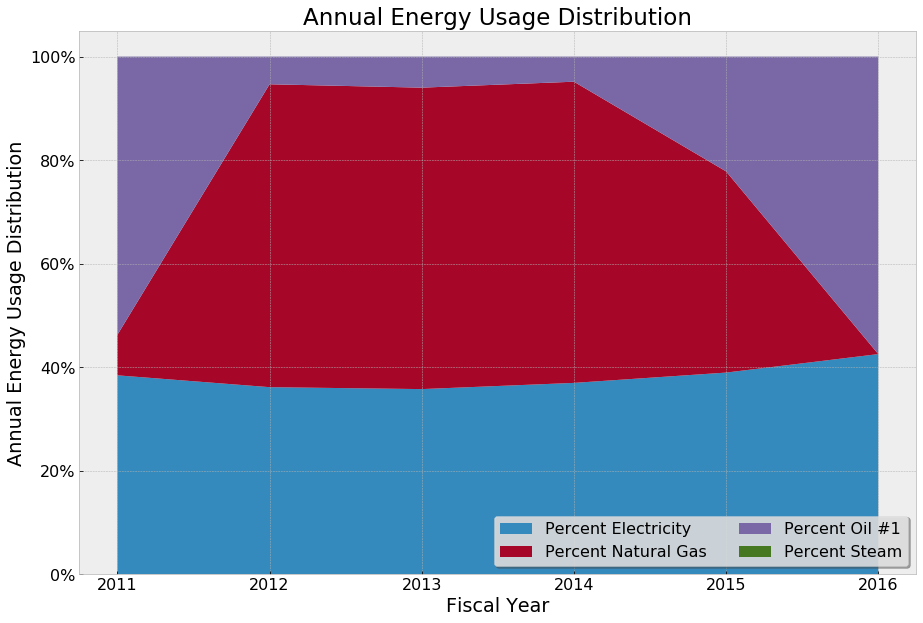

In [65]:
# Reset the index so the fiscal year column can be passed to the graphing function
reset_usage_df2 = usage_df2.reset_index()

# Only graph years with full year usage to prevent confusion
full_year_usage_df2 = reset_usage_df2.query("month_count == 12")

file_name = site + "_graph_pg4_g2.png"

# Create the area graph
gu.area_use_distribution(full_year_usage_df2, 'fiscal_year', usage_cols, file_name)

In [66]:
full_year_usage_df2

service_type,fiscal_year,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage,total_use,Percent Electricity,Percent Natural Gas,Percent Oil #1,Percent Steam
1,2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171,12,6761.947500,555.578630,11767.231736,0.425358,0.000000,0.574642,0.0
2,2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393,12,6798.165341,548.548805,11137.928659,0.389638,0.388583,0.221779,0.0
3,2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802,12,7952.991738,576.220239,12618.256760,0.369723,0.581759,0.048518,0.0
4,2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171,12,8546.673064,702.216175,13306.902370,0.357726,0.582272,0.060001,0.0
5,2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393,12,7977.362086,643.699031,12493.405421,0.361474,0.585034,0.053492,0.0
6,2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802,12,7152.616271,518.230421,11617.658529,0.384332,0.078249,0.537419,0.0


1    5005.284236
2    4339.763318
3    4665.265022
4    4760.229306
5    4516.043334
6    4465.042258
Name: Electricity, dtype: float64
1     5005.284236
2     8667.774672
3    12006.044394
4    12508.471159
5    11825.111954
6     5374.107058
dtype: float64
1    11767.231736
2    11137.928659
3    12618.256760
4    13306.902370
5    12493.405421
6    11617.658529
dtype: float64
1    11767.231736
2    11137.928659
3    12618.256760
4    13306.902370
5    12493.405421
6    11617.658529
dtype: float64


..\graph_util.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  plt.xticks(np.arange(df[fiscal_year_col].min(), df[fiscal_year_col].max()+1, 1.0),


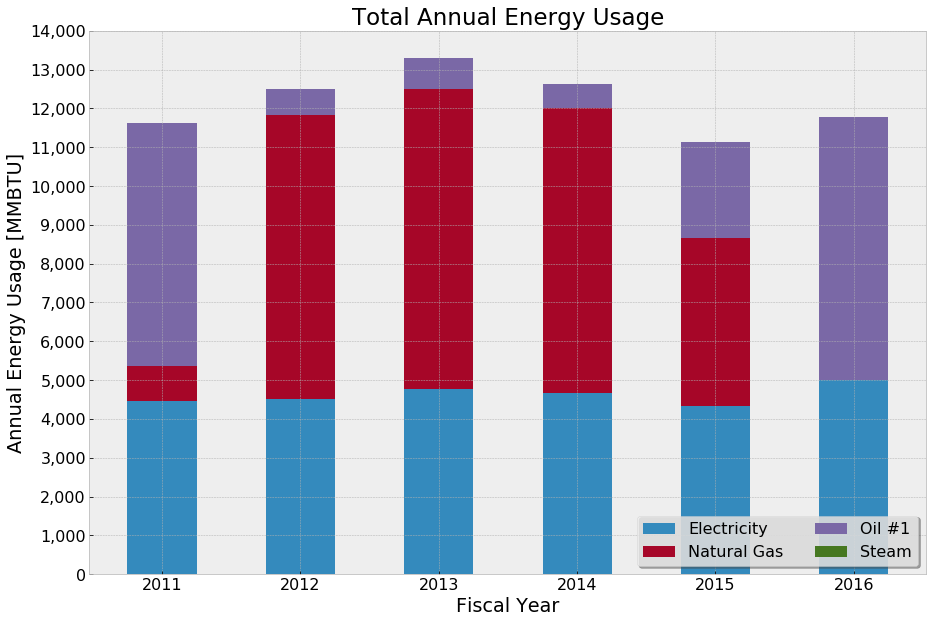

In [67]:
stacked_bar_filename = site + "_graph_pg4_g1.png"

gu.energy_use_stacked_bar(full_year_usage_df2, 'fiscal_year', usage_cols, stacked_bar_filename)

In [68]:
# Export the rows of the DataFrame into a list of dictionaries for use
# in the template.  Rename columns to match template variables.
usage_dict = bu.df_to_dictionaries(usage_df2, change_names={'Natural Gas': 'natural_gas', 'Oil #1': 'fuel_oil'})
usage_dict

[{'Electricity': 3335.3774864516131,
  'Electricity_pct_total_energy': 0.4087785763467412,
  'Natural Gas_pct_total_energy': 0.32922523711351531,
  'Oil #1_pct_total_energy': 0.26199618653974338,
  'Steam': 0.0,
  'Steam_pct_total_energy': 0.0,
  'Total_Use': 8159.3744864516138,
  'fiscal_year': 2017,
  'fuel_oil': 2137.7249999999999,
  'hdd': 13219.0,
  'month_count': 10.0,
  'natural_gas': 2686.2719999999999,
  'total_heat_energy': 4823.9969999999994,
  'total_specific_heat_usage': 364.92904153112937},
 {'Electricity': 5005.2842360483864,
  'Electricity_pct_total_energy': 0.42535783677268141,
  'Natural Gas_pct_total_energy': 0.0,
  'Oil #1_pct_total_energy': 0.57464216322731854,
  'Steam': 0.0,
  'Steam_pct_total_energy': 0.0,
  'Total_Use': 11767.231736048387,
  'fiscal_year': 2016,
  'fuel_oil': 6761.9474999999993,
  'hdd': 12171.0,
  'month_count': 12.0,
  'natural_gas': 0.0,
  'total_heat_energy': 6761.9474999999993,
  'total_specific_heat_usage': 555.57862952920868},
 {'Electri

# Create Usage Pie Charts

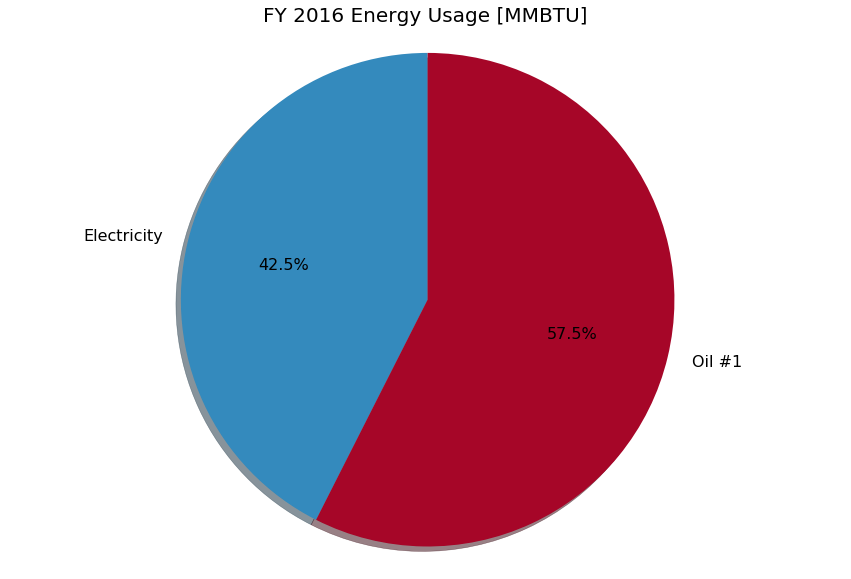

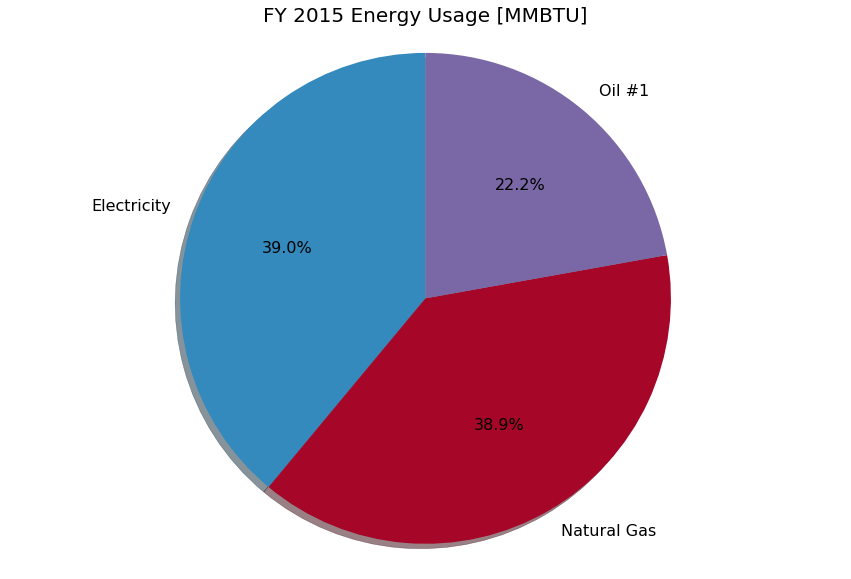

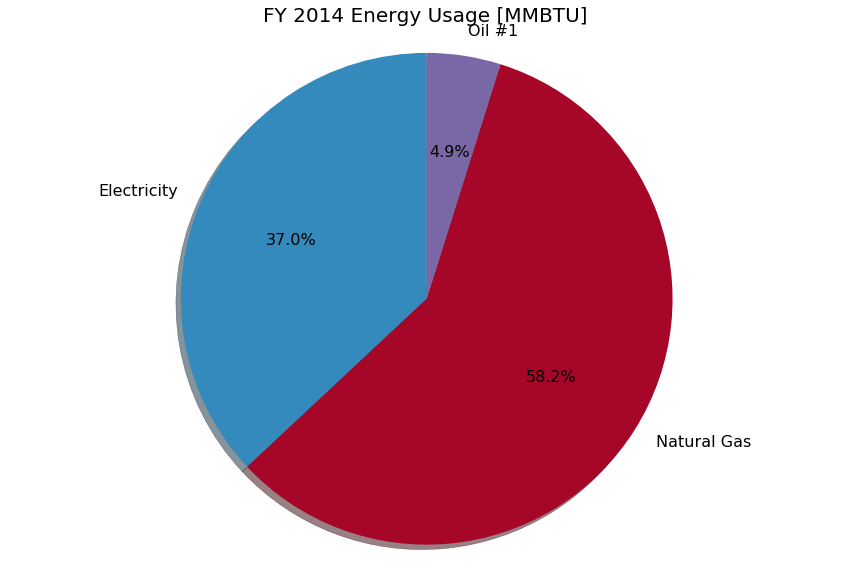

In [69]:
pie_filename = site + "_graph_pg5_"
gu.usage_pie_charts(usage_df2, usage_cols, 1, pie_filename)

# Electrical Usage Analysis - Page 6

In [70]:
site_df = df.query("site_id == @site")
site_df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
27864,DIPMP1,Electricity,2010,7,Energy charge,kWh,3055.367586,16.5,68139.310345,2011,1,232.491327
27865,DIPMP1,Electricity,2010,7,KW Charge,kW,0.000000,16.5,158.627586,2011,1,0.000000
27866,DIPMP1,Electricity,2010,7,On peak demand,-,1487.082414,16.5,0.000000,2011,1,0.000000
27867,DIPMP1,Electricity,2010,7,Other Charge,-,6597.433966,16.5,NaN,2011,1,NaN
27868,DIPMP1,Electricity,2010,8,Energy charge,kWh,5569.483929,31.0,124207.962382,2011,2,423.797568


In [71]:
# only look at elecricity records
electric_df = site_df.query("service_type == 'Electricity'")

In [72]:
# Make sure I'm not potentially missing anything with funky unit names
check_df = electric_df.query("usage > 0")
check_df.units.unique()

array(['kWh', 'kW', 'kVAR'], dtype=object)

In [73]:
electric_df = electric_df.query("units == 'kWh' or units == 'kW'")
electric_df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
27864,DIPMP1,Electricity,2010,7,Energy charge,kWh,3055.367586,16.5,68139.310345,2011,1,232.491327
27865,DIPMP1,Electricity,2010,7,KW Charge,kW,0.000000,16.5,158.627586,2011,1,0.000000
27868,DIPMP1,Electricity,2010,8,Energy charge,kWh,5569.483929,31.0,124207.962382,2011,2,423.797568
27869,DIPMP1,Electricity,2010,8,KW Charge,kW,0.000000,31.0,293.287565,2011,2,0.000000
27872,DIPMP1,Electricity,2010,9,Energy charge,kWh,5294.718140,30.0,118080.313480,2011,3,402.890030


In [74]:
electric_df.query("units == 'kWh'")['item_desc'].unique()

array(['Energy charge', 'Utility Charge'], dtype=object)

In [75]:
electric_df.item_desc.unique()

array(['Energy charge', 'KW Charge', 'On peak demand', 'Demand Charge',
       'Utility Charge'], dtype=object)

In [76]:
electric_df.to_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\electric_testing.csv")

In [77]:
electric_pivot_monthly = pd.pivot_table(electric_df,
                                        index=['fiscal_year', 'fiscal_mo'], 
                                        columns=['units'],
                                        values='usage',
                                        aggfunc=np.sum)

electric_pivot_monthly.head()

units                          kW            kWh
fiscal_year fiscal_mo                           
2011        1          158.627586   68139.310345
            2          293.287565  124207.962382
            3          307.093469  118080.313480
            4          325.981034  126864.827586
            5          283.015032  113698.836207

In [78]:
electric_pivot_annual = pd.pivot_table(electric_df,
                                       index=['fiscal_year'],
                                       columns=['units'],
                                       values='usage',
                                       aggfunc=np.sum
                                      )
                                       
electric_use_annual = electric_pivot_annual[['kWh']]
electric_use_annual = electric_use_annual.rename(columns={'kWh':'ann_electric_usage_kWh'})
electric_use_annual

units,ann_electric_usage_kWh
fiscal_year,
2011,1.308629e+06
2012,1.323577e+06
2013,1.395143e+06
2014,1.367311e+06
2015,1.271912e+06
2016,1.466965e+06
2017,9.775432e+05


In [79]:
# Get average annual demand usage
electric_demand_avg = electric_pivot_monthly.groupby(['fiscal_year']).mean()
electric_demand_avg = electric_demand_avg[['kW']]
electric_demand_avg = electric_demand_avg.rename(columns={'kW': 'avg_demand_kW'})
electric_demand_avg

units,avg_demand_kW
fiscal_year,
2011,289.213172
2012,265.742687
2013,278.553146
2014,249.558703
2015,257.109245
2016,275.680036
2017,233.681613


In [80]:
# Find annual maximum demand usage
electric_demand_max = electric_pivot_monthly.groupby(['fiscal_year']).max()
electric_demand_max = electric_demand_max[['kW']]
electric_demand_max = electric_demand_max.rename(columns={'kW': 'max_demand_kW'})
electric_demand_max

units,max_demand_kW
fiscal_year,
2011,430.021119
2012,287.280311
2013,303.987857
2014,294.672414
2015,287.567186
2016,294.307489
2017,295.459455


In [81]:
# Combine dataframes
electric_demand_join = pd.merge(electric_demand_max, electric_demand_avg, how='outer', left_index=True, right_index=True)
annual_electric_data = pd.merge(electric_demand_join, electric_use_annual, how='outer', left_index=True, right_index=True)
annual_electric_data

units,max_demand_kW,avg_demand_kW,ann_electric_usage_kWh
fiscal_year,,,
2011,430.021119,289.213172,1.308629e+06
2012,287.280311,265.742687,1.323577e+06
2013,303.987857,278.553146,1.395143e+06
2014,294.672414,249.558703,1.367311e+06
2015,287.567186,257.109245,1.271912e+06
2016,294.307489,275.680036,1.466965e+06
2017,295.459455,233.681613,9.775432e+05


In [82]:
# Add percent change columns
annual_electric_data['usage_pct_change'] = annual_electric_data.ann_electric_usage_kWh.pct_change()
annual_electric_data['avg_demand_pct_change'] = annual_electric_data.avg_demand_kW.pct_change()
annual_electric_data['max_demand_pct_change'] = annual_electric_data.max_demand_kW.pct_change()
annual_electric_data = annual_electric_data.rename(columns={'avg_demand_kW': 'Average kW',
                                                           'ann_electric_usage_kWh': 'Total kWh'})
annual_electric_data

units,max_demand_kW,Average kW,Total kWh,usage_pct_change,avg_demand_pct_change,max_demand_pct_change
fiscal_year,,,,,,
2011,430.021119,289.213172,1.308629e+06,NaN,NaN,NaN
2012,287.280311,265.742687,1.323577e+06,0.011422,-0.081153,-0.331939
2013,303.987857,278.553146,1.395143e+06,0.054071,0.048206,0.058158
2014,294.672414,249.558703,1.367311e+06,-0.019950,-0.104089,-0.030644
2015,287.567186,257.109245,1.271912e+06,-0.069771,0.030256,-0.024112
2016,294.307489,275.680036,1.466965e+06,0.153354,0.072229,0.023439
2017,295.459455,233.681613,9.775432e+05,-0.333629,-0.152345,0.003914


## Create Electrical Usage Analysis Graphs - Page 6

In [83]:
# Axes labels
ylabel1 = 'Electricity Usage [kWh]'
ylabel2 = 'Electricity Demand [kW]'

stacked_line_file = site + "_graph_pg6_g1.png"

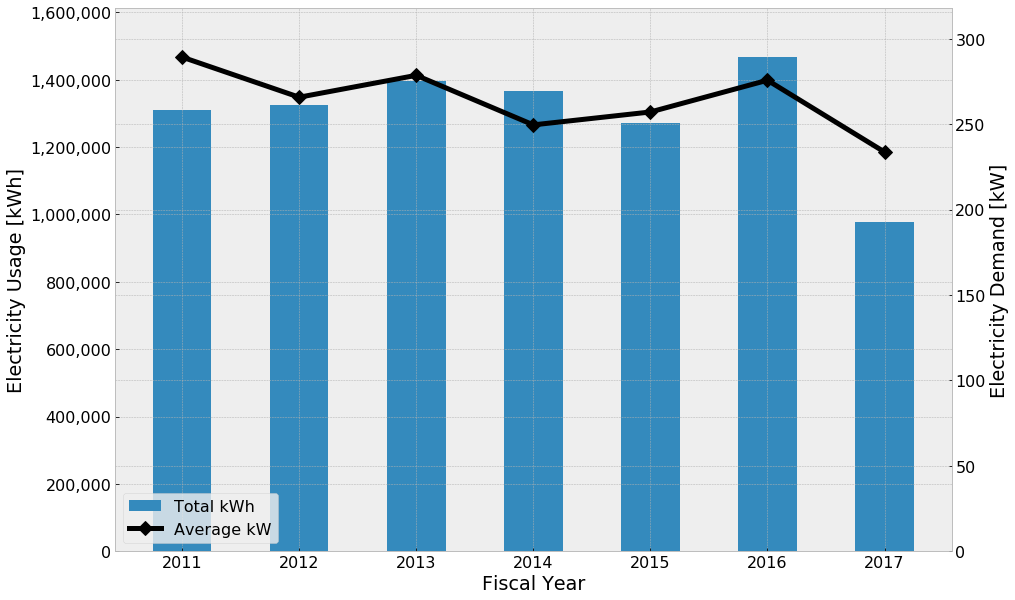

In [84]:
gu.stacked_bar_with_line(annual_electric_data.reset_index(), 'fiscal_year', ['Total kWh'], 'Average kW', 
                      ylabel1, ylabel2, stacked_line_file)

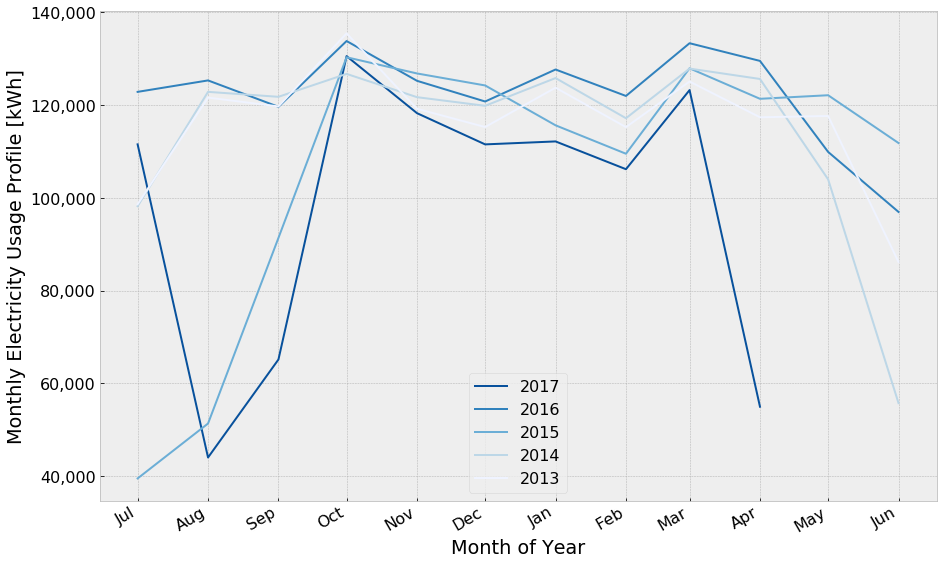

In [85]:
month_profile_filename = site + "_graph_pg6_g2.png"
gu.create_monthly_profile(electric_pivot_monthly, 'kWh', 'Monthly Electricity Usage Profile [kWh]', 'blue',
                         month_profile_filename)

## Electrical Cost Analysis Table - Page 7

In [86]:
# only look at elecricity records
electric_cost_df = site_df.query("service_type == 'Electricity'")

In [87]:
electric_cost_df.item_desc.unique()

array(['Energy charge', 'KW Charge', 'On peak demand', 'Other Charge',
       'Demand Charge', 'Utility Charge', 'kVAR'], dtype=object)

In [88]:
# Costs don't always have units, so split the data into demand charges and usage charges (which includes other charges)
electric_cost_df['cost_categories'] = np.where(electric_cost_df.item_desc.isin(['KW Charge', 'On peak demand', 'Demand Charge']),
                                               'demand_cost', 'usage_cost')

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [89]:
electric_cost_df.to_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\electric_cost_testing.csv")

In [90]:
# Sum costs by demand and usage
electric_annual_cost = pd.pivot_table(electric_cost_df,
                                       index=['fiscal_year'],
                                       columns=['cost_categories'],
                                       values='cost',
                                       aggfunc=np.sum
                                      )
# Create a total column
electric_annual_cost['Total Cost'] = electric_annual_cost.demand_cost + electric_annual_cost.usage_cost

electric_annual_cost

cost_categories,demand_cost,usage_cost,Total Cost
fiscal_year,,,
2011,31463.674194,187954.246290,219417.920484
2012,34696.867525,225266.682772,259963.550297
2013,38146.446023,236993.286421,275139.732445
2014,39515.007883,211917.016079,251432.023962
2015,40119.548906,187021.650625,227141.199531
2016,45560.764985,199518.886683,245079.651668
2017,33391.390484,152914.001129,186305.391613


In [91]:
# Add percent change columns
electric_annual_cost['usage_cost_pct_change'] = electric_annual_cost.usage_cost.pct_change()
electric_annual_cost['demand_cost_pct_change'] = electric_annual_cost.demand_cost.pct_change()
electric_annual_cost['total_cost_pct_change'] = electric_annual_cost['Total Cost'].pct_change()
electric_annual_cost

cost_categories,demand_cost,usage_cost,Total Cost,usage_cost_pct_change,demand_cost_pct_change,total_cost_pct_change
fiscal_year,,,,,,
2011,31463.674194,187954.246290,219417.920484,NaN,NaN,NaN
2012,34696.867525,225266.682772,259963.550297,0.198519,0.102760,0.184787
2013,38146.446023,236993.286421,275139.732445,0.052057,0.099420,0.058378
2014,39515.007883,211917.016079,251432.023962,-0.105810,0.035877,-0.086166
2015,40119.548906,187021.650625,227141.199531,-0.117477,0.015299,-0.096610
2016,45560.764985,199518.886683,245079.651668,0.066822,0.135625,0.078975
2017,33391.390484,152914.001129,186305.391613,-0.233586,-0.267102,-0.239817


In [92]:
electric_use_and_cost = pd.merge(electric_annual_cost, annual_electric_data, left_index=True, right_index=True, how='outer')
electric_use_and_cost

,demand_cost,usage_cost,Total Cost,usage_cost_pct_change,demand_cost_pct_change,total_cost_pct_change,max_demand_kW,Average kW,Total kWh,usage_pct_change,avg_demand_pct_change,max_demand_pct_change
fiscal_year,,,,,,,,,,,,
2011,31463.674194,187954.246290,219417.920484,NaN,NaN,NaN,430.021119,289.213172,1.308629e+06,NaN,NaN,NaN
2012,34696.867525,225266.682772,259963.550297,0.198519,0.102760,0.184787,287.280311,265.742687,1.323577e+06,0.011422,-0.081153,-0.331939
2013,38146.446023,236993.286421,275139.732445,0.052057,0.099420,0.058378,303.987857,278.553146,1.395143e+06,0.054071,0.048206,0.058158
2014,39515.007883,211917.016079,251432.023962,-0.105810,0.035877,-0.086166,294.672414,249.558703,1.367311e+06,-0.019950,-0.104089,-0.030644
2015,40119.548906,187021.650625,227141.199531,-0.117477,0.015299,-0.096610,287.567186,257.109245,1.271912e+06,-0.069771,0.030256,-0.024112
2016,45560.764985,199518.886683,245079.651668,0.066822,0.135625,0.078975,294.307489,275.680036,1.466965e+06,0.153354,0.072229,0.023439
2017,33391.390484,152914.001129,186305.391613,-0.233586,-0.267102,-0.239817,295.459455,233.681613,9.775432e+05,-0.333629,-0.152345,0.003914


## Create Electrical Cost Analysis Graphs - Page 7

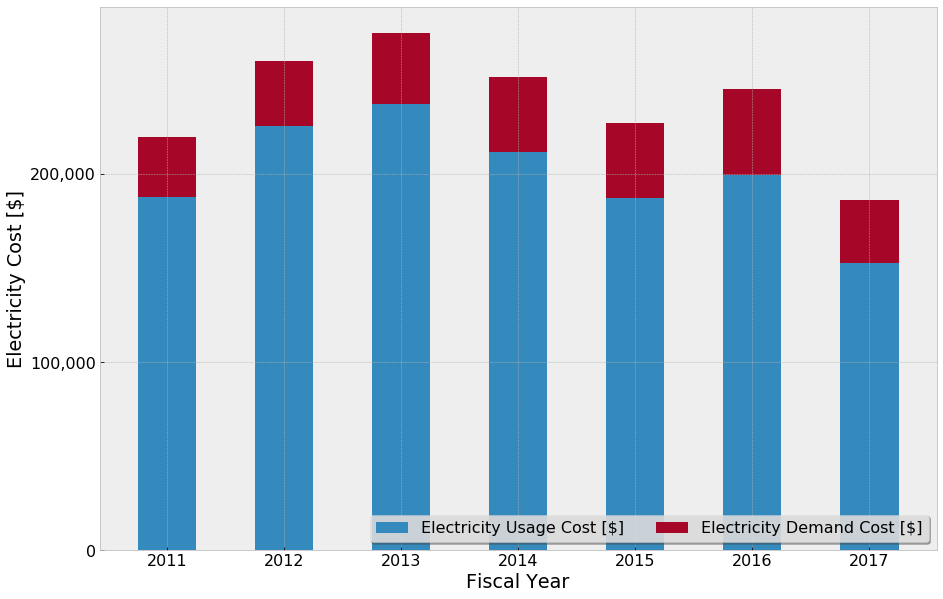

In [93]:
elec_cost_filename = site + "_graph_pg7_g1.png"
renamed_use_and_cost = electric_use_and_cost.rename(columns={'usage_cost':'Electricity Usage Cost [$]',
                                                            'demand_cost':'Electricity Demand Cost [$]'})
gu.create_stacked_bar(renamed_use_and_cost.reset_index(), 'fiscal_year', ['Electricity Usage Cost [$]', 
                                                                          'Electricity Demand Cost [$]'], 
                      'Electricity Cost [$]', elec_cost_filename)

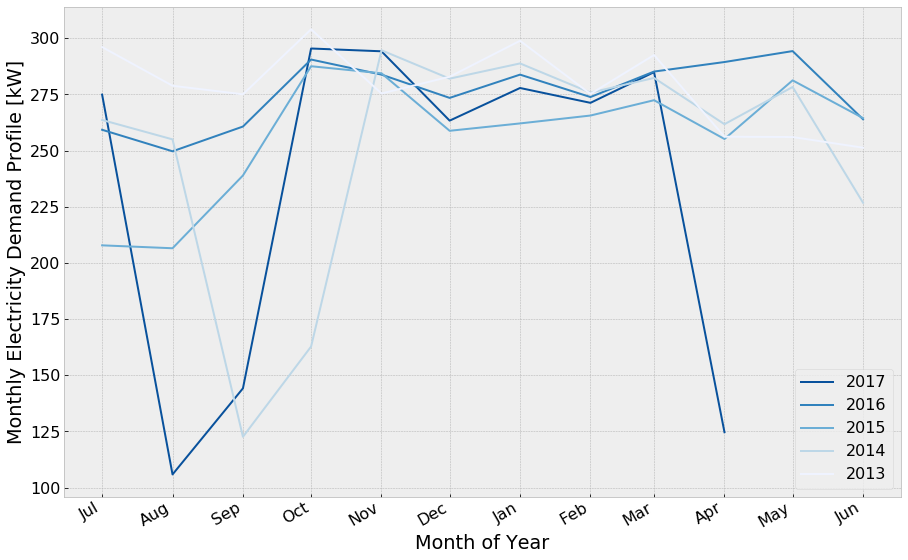

In [94]:
# Create Monthly Profile of Electricity Demand
monthly_demand_filename = site + "_graph_pg7_g2.png"
gu.create_monthly_profile(electric_pivot_monthly, 'kW', 'Monthly Electricity Demand Profile [kW]', 'blue', 
                          monthly_demand_filename)

# Create Heating Usage Analysis Table - Page 8

In [95]:
# Take only needed columns from earlier usage df
heating_usage = usage_df2[['Natural Gas', 'Oil #1', 'Steam', 'hdd', 'month_count', 'total_heat_energy']]
heating_usage

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy
fiscal_year,,,,,,
2017,2686.272000,2137.725000,0.0,13219,10,4823.997000
2016,0.000000,6761.947500,0.0,12171,12,6761.947500
2015,4328.011355,2470.153986,0.0,12393,12,6798.165341
2014,7340.779372,612.212365,0.0,13802,12,7952.991738
2013,7748.241853,798.431211,0.0,12171,12,8546.673064
2012,7309.068619,668.293467,0.0,12393,12,7977.362086
2011,909.064800,6243.551471,0.0,13802,12,7152.616271


In [96]:
# Add in percent change columns
heating_usage['Oil #1_pct_change'] = heating_usage['Oil #1'].pct_change()
heating_usage['Natural Gas_pct_change'] = heating_usage['Natural Gas'].pct_change()
heating_usage['Steam_pct_change'] = heating_usage['Steam'].pct_change()
heating_usage['total_heat_energy_pct_change'] = heating_usage.total_heat_energy.pct_change()
heating_usage

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change
fiscal_year,,,,,,,,,,
2017,2686.272000,2137.725000,0.0,13219,10,4823.997000,NaN,NaN,NaN,NaN
2016,0.000000,6761.947500,0.0,12171,12,6761.947500,2.163151,-1.000000,NaN,0.401731
2015,4328.011355,2470.153986,0.0,12393,12,6798.165341,-0.634698,inf,NaN,0.005356
2014,7340.779372,612.212365,0.0,13802,12,7952.991738,-0.752156,0.696109,NaN,0.169873
2013,7748.241853,798.431211,0.0,12171,12,8546.673064,0.304174,0.055507,NaN,0.074649
2012,7309.068619,668.293467,0.0,12393,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612
2011,909.064800,6243.551471,0.0,13802,12,7152.616271,8.342530,-0.875625,NaN,-0.103386


In [97]:
# Get the number of gallons, ccf, and 1,000 pounds of district heat by converting MMBTUs using the supplied conversions
heating_usage['Oil #1 Gallons'] = heating_usage['Oil #1'] * 1000000 / ut.fuel_btus_per_unit('Oil #1', 'gallons')
heating_usage['Natural Gas ccf'] = heating_usage['Natural Gas'] * 1000000 / ut.fuel_btus_per_unit('Natural Gas', 'ccf')
heating_usage

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
fiscal_year,,,,,,,,,,,,
2017,2686.272000,2137.725000,0.0,13219,10,4823.997000,NaN,NaN,NaN,NaN,15835.000000,26336.000000
2016,0.000000,6761.947500,0.0,12171,12,6761.947500,2.163151,-1.000000,NaN,0.401731,50088.500000,0.000000
2015,4328.011355,2470.153986,0.0,12393,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
2014,7340.779372,612.212365,0.0,13802,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
2013,7748.241853,798.431211,0.0,12171,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
2012,7309.068619,668.293467,0.0,12393,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
2011,909.064800,6243.551471,0.0,13802,12,7152.616271,8.342530,-0.875625,NaN,-0.103386,46248.529412,8912.400000


## Create Heating Usage Analysis Graphs - Page 8

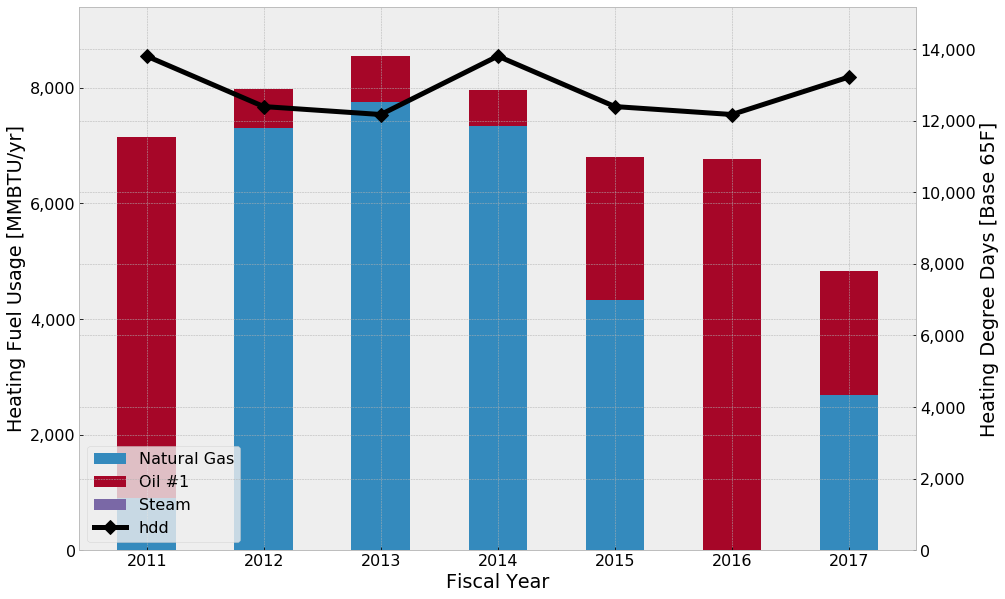

In [98]:
use_with_hdd_filename = site + '_graph_pg8_g1.png'
gu.stacked_bar_with_line(heating_usage.reset_index(), 'fiscal_year', ['Natural Gas', 'Oil #1', 'Steam'], 'hdd',
                        'Heating Fuel Usage [MMBTU/yr]', 'Heating Degree Days [Base 65F]', use_with_hdd_filename)

### Create Monthly Heating Usage dataframe for graph

In [99]:
monthly_heating = pd.pivot_table(usage_df1,
                                values='mmbtu',
                                index=['fiscal_year', 'fiscal_mo'],
                                columns=['service_type'],
                                aggfunc=np.sum
                                )
monthly_heating

service_type           Electricity  Natural Gas       Oil #1  Sewer  Water
fiscal_year fiscal_mo                                                     
2011        1           232.491327     1.954452    98.738372    NaN    NaN
            2           423.797568    39.266710   165.309128    0.0    0.0
            3           402.890030    16.380701   506.870000    0.0    0.0
            4           432.862792     4.297794   780.918750    0.0    0.0
            5           387.940429     4.973654   899.490000    0.0    0.0
            6           366.575512   235.910172   960.076103    0.0    0.0
            7           370.602635   131.921972  1020.090772    0.0    0.0
            8           338.652871    70.967273   756.894375    0.0    0.0
            9           393.901327    43.087273   636.298676    0.0    0.0
            10          393.160092     9.786000   203.815774    0.0    0.0
            11          397.177978    89.679828   153.156760    0.0    0.0
            12          324.989698   260.838972    61.892761    0.0    0.0
2012        1           345.409811   210.826669    73.988389    0.0    0.0
            2           400.015138   281.787431    23.577465    0.0    0.0
            3           395.211129   435.087694    46.517364    0.0    0.0
            4           436.909826   590.624130   100.810312    0.0    0.0
            5           400.769117  1015.978034    67.687358    0.0    0.0
            6           358.723631   866.548514    47.377358    0.0    0.0
            7           346.543829  1238.691038    60.206383    0.0    0.0
            8           355.182141   825.743990    84.431400    0.0    0.0
            9           402.343040   837.836606    42.036222    0.0    0.0
            10          387.328039   478.561794    38.459659    0.0    0.0
            11          391.365205   354.747719    39.741648    0.0    0.0
            12          296.242429   172.635000    43.459909    0.0    0.0
2013        1           336.512250   202.910903    44.996148    0.0    0.0
            2           414.941487   262.674677    44.996148    0.0    0.0
            3           408.448656   382.801364    43.544659    0.0    0.0
            4           462.218278   682.836836    44.996148    0.0    0.0
            5           406.717224   990.921994    51.119148    0.0    0.0
            6           393.281195  1019.501516   170.713125    0.0    0.0
...                            ...          ...          ...    ...    ...
2015        5           432.705202   744.073548    60.867961    0.0    0.0
            6           423.877204   796.373226    62.896893    0.0    0.0
            7           394.553437  1092.491036    67.074735    0.0    0.0
            8           373.636859   590.508964   331.295192    0.0    0.0
            9           436.488935     0.000000   737.919643    0.0    0.0
            10          414.053450     0.000000   498.858312    0.0    0.0
            11          416.682146     0.000000   323.552045    0.0    0.0
            12          381.513883     0.000000   198.450000    0.0    0.0
2016        1           419.162205     0.000000   307.415543    0.0    0.0
            2           427.578907     0.000000   324.890707    0.0    0.0
            3           408.168442     0.000000   403.380000    0.0    0.0
            4           456.565995     0.000000   610.098750    0.0    0.0
            5           427.290630     0.000000   848.390625    0.0    0.0
            6           412.070611     0.000000   948.459375    0.0    0.0
            7           435.612172     0.000000   794.880000    0.0    0.0
            8           416.148845     0.000000   775.110937    0.0    0.0
            9           454.948403     0.000000   701.620312    0.0    0.0
            10          441.933300     0.000000   439.661250    0.0    0.0
            11          374.986080     0.000000   413.398929    0.0    0.0
            12          330.818646     0.000000   194.641071    0.0    0.0
2017        1           3

In [100]:
# Add in columns for the missing energy services
missing_services = bu.missing_energy_services(monthly_heating.columns)
bu.add_columns(monthly_heating, missing_services)

# Drop the non-heating services
monthly_heating = monthly_heating.drop(labels=['Electricity', 'Sewer', 'Water'], axis=1)

# Create a total heating column
monthly_heating['total_heating_energy'] = monthly_heating.sum(axis=1)

monthly_heating

service_type           Natural Gas       Oil #1  Steam  total_heating_energy
fiscal_year fiscal_mo                                                       
2011        1             1.954452    98.738372    0.0            100.692824
            2            39.266710   165.309128    0.0            204.575838
            3            16.380701   506.870000    0.0            523.250701
            4             4.297794   780.918750    0.0            785.216544
            5             4.973654   899.490000    0.0            904.463654
            6           235.910172   960.076103    0.0           1195.986275
            7           131.921972  1020.090772    0.0           1152.012744
            8            70.967273   756.894375    0.0            827.861648
            9            43.087273   636.298676    0.0            679.385949
            10            9.786000   203.815774    0.0            213.601774
            11           89.679828   153.156760    0.0            242.836587
            12          260.838972    61.892761    0.0            322.731733
2012        1           210.826669    73.988389    0.0            284.815057
            2           281.787431    23.577465    0.0            305.364896
            3           435.087694    46.517364    0.0            481.605057
            4           590.624130   100.810312    0.0            691.434443
            5          1015.978034    67.687358    0.0           1083.665393
            6           866.548514    47.377358    0.0            913.925873
            7          1238.691038    60.206383    0.0           1298.897421
            8           825.743990    84.431400    0.0            910.175390
            9           837.836606    42.036222    0.0            879.872828
            10          478.561794    38.459659    0.0            517.021453
            11          354.747719    39.741648    0.0            394.489367
            12          172.635000    43.459909    0.0            216.094909
2013        1           202.910903    44.996148    0.0            247.907051
            2           262.674677    44.996148    0.0            307.670825
            3           382.801364    43.544659    0.0            426.346023
            4           682.836836    44.996148    0.0            727.832984
            5           990.921994    51.119148    0.0           1042.041141
            6          1019.501516   170.713125    0.0           1190.214641
...                            ...          ...    ...                   ...
2015        5           744.073548    60.867961    0.0            804.941510
            6           796.373226    62.896893    0.0            859.270119
            7          1092.491036    67.074735    0.0           1159.565771
            8           590.508964   331.295192    0.0            921.804157
            9             0.000000   737.919643    0.0            737.919643
            10            0.000000   498.858312    0.0            498.858312
            11            0.000000   323.552045    0.0            323.552045
            12            0.000000   198.450000    0.0            198.450000
2016        1             0.000000   307.415543    0.0            307.415543
            2             0.000000   324.890707    0.0            324.890707
            3             0.000000   403.380000    0.0            403.380000
            4             0.000000   610.098750    0.0            610.098750
            5             0.000000   848.390625    0.0            848.390625
            6             0.000000   948.459375    0.0            948.459375
            7             0.000000   794.880000    0.0            794.880000
            8             0.000000   775.110937    0.0            775.110937
            9             0.000000   701.620312    0.0            701.620312
            10            0.000000   439.661250    0.0            439.661250
            11            0.000000   413.398929    0.0            413.398

In [101]:
# Identify partial years through the use of the month_count utility
reset_monthly_heating = monthly_heating.reset_index()
months_present = bu.months_present(reset_monthly_heating)
mo_count = bu.month_count(months_present)
mo_count_df = pd.DataFrame(mo_count)
mo_count_df

,month
year,
2011,12
2012,12
2013,12
2014,12
2015,12
2016,12
2017,10


In [102]:
# Only send records for full years to graphing function
reset_monthly_heating = pd.merge(reset_monthly_heating, mo_count_df, left_on='fiscal_year', right_index=True, how='left')
full_year_monthly_heating = reset_monthly_heating.query("month == 12")
full_year_monthly_heating = full_year_monthly_heating.set_index(['fiscal_year', 'fiscal_mo'])
full_year_monthly_heating

Natural Gas       Oil #1  Steam  total_heating_energy  \
fiscal_year fiscal_mo                                                          
2011        1             1.954452    98.738372    0.0            100.692824   
            2            39.266710   165.309128    0.0            204.575838   
            3            16.380701   506.870000    0.0            523.250701   
            4             4.297794   780.918750    0.0            785.216544   
            5             4.973654   899.490000    0.0            904.463654   
            6           235.910172   960.076103    0.0           1195.986275   
            7           131.921972  1020.090772    0.0           1152.012744   
            8            70.967273   756.894375    0.0            827.861648   
            9            43.087273   636.298676    0.0            679.385949   
            10            9.786000   203.815774    0.0            213.601774   
            11           89.679828   153.156760    0.0            242.836587   
            12          260.838972    61.892761    0.0            322.731733   
2012        1           210.826669    73.988389    0.0            284.815057   
            2           281.787431    23.577465    0.0            305.364896   
            3           435.087694    46.517364    0.0            481.605057   
            4           590.624130   100.810312    0.0            691.434443   
            5          1015.978034    67.687358    0.0           1083.665393   
            6           866.548514    47.377358    0.0            913.925873   
            7          1238.691038    60.206383    0.0           1298.897421   
            8           825.743990    84.431400    0.0            910.175390   
            9           837.836606    42.036222    0.0            879.872828   
            10          478.561794    38.459659    0.0            517.021453   
            11          354.747719    39.741648    0.0            394.489367   
            12          172.635000    43.459909    0.0            216.094909   
2013        1           202.910903    44.996148    0.0            247.907051   
            2           262.674677    44.996148    0.0            307.670825   
            3           382.801364    43.544659    0.0            426.346023   
            4           682.836836    44.996148    0.0            727.832984   
            5           990.921994    51.119148    0.0           1042.041141   
            6          1019.501516   170.713125    0.0           1190.214641   
...                            ...          ...    ...                   ...   
2014        7           879.803644    63.832263    0.0            943.635907   
            8           922.445872    57.654947    0.0            980.100819   
            9           748.115106    59.263265    0.0            807.378372   
            10          512.899377    36.851351    0.0            549.750729   
            11          337.352223    38.079730    0.0            375.431952   
            12          176.806745    36.851351    0.0            213.658097   
2015        1            98.540226    43.002904    0.0            141.543130   
            2           126.898529    47.329330    0.0            174.227859   
            3           302.328987    45.802577    0.0            348.131564   
            4           576.796839    53.104394    0.0            629.901232   
            5           744.073548    60.867961    0.0            804.941510   
            6           796.373226    62.896893    0.0            859.270119   
            7          1092.491036    67.074735    0.0           1159.565771   
            8           590.508964   331.295192    0.0            921.804157   
            9             0.000000   737.919643    0.0            737.919643   
            10            0.000000   498.858312    0.0            498.858312   
            11            0.000000   323.552045    0.0            323.552045   
            12         

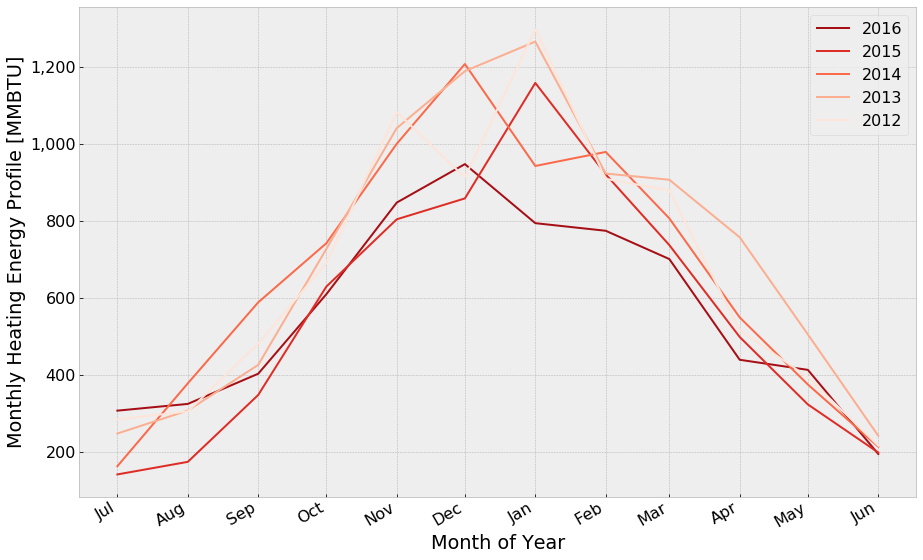

In [103]:
heat_profile_filename = site + '_graph_pg8_g2.png'
gu.create_monthly_profile(full_year_monthly_heating, 'total_heating_energy', "Monthly Heating Energy Profile [MMBTU]", 'red',
                          heat_profile_filename)

## Heating Cost Analysis Table - Page 9

In [104]:
# Import df that I exported from "alan_report_pages".  This can be removed once code is combined
df2 = pd.read_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\data_from_alan_report_pages_df2.csv")

# Use only necessary columns
heating_cost = df2[['fiscal_year', 'Natural Gas', 'Oil #1', 'Steam', 'Total', 'pct_change']]

# Change column names so they aren't the same as the heating usage dataframe
heating_cost = heating_cost.rename(columns={'Natural Gas':'Natural Gas Cost',
                                           'Oil #1': 'Oil #1 Cost',
                                           'Steam': 'Steam Cost',
                                           'Total': 'Total Heat Cost',
                                           'pct_change': 'Total Cost % Change'})
heating_cost

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN


In [105]:
heating_usage

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
fiscal_year,,,,,,,,,,,,
2017,2686.272000,2137.725000,0.0,13219,10,4823.997000,NaN,NaN,NaN,NaN,15835.000000,26336.000000
2016,0.000000,6761.947500,0.0,12171,12,6761.947500,2.163151,-1.000000,NaN,0.401731,50088.500000,0.000000
2015,4328.011355,2470.153986,0.0,12393,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
2014,7340.779372,612.212365,0.0,13802,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
2013,7748.241853,798.431211,0.0,12171,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
2012,7309.068619,668.293467,0.0,12393,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
2011,909.064800,6243.551471,0.0,13802,12,7152.616271,8.342530,-0.875625,NaN,-0.103386,46248.529412,8912.400000


In [106]:
# Combine the heating cost and heating use dataframes
heating_cost_and_use = pd.merge(heating_cost, heating_usage, left_on='fiscal_year', right_index=True, how='outer')
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,2686.272000,2137.725000,0.0,13219,10,4823.997000,NaN,NaN,NaN,NaN,15835.000000,26336.000000
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171,12,6761.947500,2.163151,-1.000000,NaN,0.401731,50088.500000,0.000000
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,909.064800,6243.551471,0.0,13802,12,7152.616271,8.342530,-0.875625,NaN,-0.103386,46248.529412,8912.400000


In [107]:
# Create percent change columns
heating_cost_and_use['oil_cost_pct_change'] = heating_cost_and_use['Oil #1 Cost'].pct_change()
heating_cost_and_use['natural_gas_cost_pct_change'] = heating_cost_and_use['Natural Gas Cost'].pct_change()
heating_cost_and_use['steam_cost_pct_change'] = heating_cost_and_use['Steam Cost'].pct_change()

In [108]:
# Create unit cost columns
heating_cost_and_use['oil_unit_cost'] = heating_cost_and_use['Oil #1 Cost'] / heating_cost_and_use['Oil #1']
heating_cost_and_use['natural_gas_unit_cost'] = heating_cost_and_use['Natural Gas Cost'] / heating_cost_and_use['Natural Gas']
heating_cost_and_use['steam_unit_cost'] = heating_cost_and_use['Steam Cost'] / heating_cost_and_use['Steam']
heating_cost_and_use['building_unit_heat_cost'] = heating_cost_and_use['Total Heat Cost'] / heating_cost_and_use.total_heat_energy
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,...,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf,oil_cost_pct_change,natural_gas_cost_pct_change,steam_cost_pct_change,oil_unit_cost,natural_gas_unit_cost,steam_unit_cost,building_unit_heat_cost
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,2686.272000,2137.725000,0.0,13219,...,NaN,15835.000000,26336.000000,NaN,NaN,NaN,13.578957,19.855384,NaN,61.048158
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171,...,0.401731,50088.500000,0.000000,2.112477,-0.987054,NaN,13.361421,inf,NaN,55.258679
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393,...,0.005356,18297.436937,42431.483871,-0.460879,139.663957,NaN,19.719083,22.441116,NaN,60.460866
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802,...,0.169873,4534.906411,71968.425220,-0.676711,0.692242,NaN,25.721687,22.389946,NaN,59.215932
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171,...,0.074649,5914.305263,75963.155425,0.293526,0.053205,NaN,25.511686,22.341126,NaN,59.463636
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393,...,-0.066612,4950.321977,71657.535484,-0.148164,-0.054828,NaN,25.963645,22.384987,NaN,60.782718
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,909.064800,6243.551471,0.0,13802,...,-0.103386,46248.529412,8912.400000,7.021588,-0.872243,NaN,22.292643,22.993704,NaN,58.548124


In [109]:
# Remove all columns not needed for the Heating Cost Analysis Table
heating_cost_and_use[['fiscal_year', 'Oil #1 Cost', 'oil_cost_pct_change', 'Natural Gas Cost', 'natural_gas_cost_pct_change',
                     'Steam Cost', 'steam_cost_pct_change', 'oil_unit_cost', 'natural_gas_unit_cost', 'steam_unit_cost',
                     'building_unit_heat_cost', 'Total Heat Cost', 'Total Cost % Change']]
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,...,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf,oil_cost_pct_change,natural_gas_cost_pct_change,steam_cost_pct_change,oil_unit_cost,natural_gas_unit_cost,steam_unit_cost,building_unit_heat_cost
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,2686.272000,2137.725000,0.0,13219,...,NaN,15835.000000,26336.000000,NaN,NaN,NaN,13.578957,19.855384,NaN,61.048158
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171,...,0.401731,50088.500000,0.000000,2.112477,-0.987054,NaN,13.361421,inf,NaN,55.258679
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393,...,0.005356,18297.436937,42431.483871,-0.460879,139.663957,NaN,19.719083,22.441116,NaN,60.460866
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802,...,0.169873,4534.906411,71968.425220,-0.676711,0.692242,NaN,25.721687,22.389946,NaN,59.215932
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171,...,0.074649,5914.305263,75963.155425,0.293526,0.053205,NaN,25.511686,22.341126,NaN,59.463636
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393,...,-0.066612,4950.321977,71657.535484,-0.148164,-0.054828,NaN,25.963645,22.384987,NaN,60.782718
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,909.064800,6243.551471,0.0,13802,...,-0.103386,46248.529412,8912.400000,7.021588,-0.872243,NaN,22.292643,22.993704,NaN,58.548124


## Monthly Cost Per MMBTU: Data and Graphs - Page 9

In [110]:
# Heating energy use, in MMBTUs
monthly_heating

service_type           Natural Gas       Oil #1  Steam  total_heating_energy
fiscal_year fiscal_mo                                                       
2011        1             1.954452    98.738372    0.0            100.692824
            2            39.266710   165.309128    0.0            204.575838
            3            16.380701   506.870000    0.0            523.250701
            4             4.297794   780.918750    0.0            785.216544
            5             4.973654   899.490000    0.0            904.463654
            6           235.910172   960.076103    0.0           1195.986275
            7           131.921972  1020.090772    0.0           1152.012744
            8            70.967273   756.894375    0.0            827.861648
            9            43.087273   636.298676    0.0            679.385949
            10            9.786000   203.815774    0.0            213.601774
            11           89.679828   153.156760    0.0            242.836587
            12          260.838972    61.892761    0.0            322.731733
2012        1           210.826669    73.988389    0.0            284.815057
            2           281.787431    23.577465    0.0            305.364896
            3           435.087694    46.517364    0.0            481.605057
            4           590.624130   100.810312    0.0            691.434443
            5          1015.978034    67.687358    0.0           1083.665393
            6           866.548514    47.377358    0.0            913.925873
            7          1238.691038    60.206383    0.0           1298.897421
            8           825.743990    84.431400    0.0            910.175390
            9           837.836606    42.036222    0.0            879.872828
            10          478.561794    38.459659    0.0            517.021453
            11          354.747719    39.741648    0.0            394.489367
            12          172.635000    43.459909    0.0            216.094909
2013        1           202.910903    44.996148    0.0            247.907051
            2           262.674677    44.996148    0.0            307.670825
            3           382.801364    43.544659    0.0            426.346023
            4           682.836836    44.996148    0.0            727.832984
            5           990.921994    51.119148    0.0           1042.041141
            6          1019.501516   170.713125    0.0           1190.214641
...                            ...          ...    ...                   ...
2015        5           744.073548    60.867961    0.0            804.941510
            6           796.373226    62.896893    0.0            859.270119
            7          1092.491036    67.074735    0.0           1159.565771
            8           590.508964   331.295192    0.0            921.804157
            9             0.000000   737.919643    0.0            737.919643
            10            0.000000   498.858312    0.0            498.858312
            11            0.000000   323.552045    0.0            323.552045
            12            0.000000   198.450000    0.0            198.450000
2016        1             0.000000   307.415543    0.0            307.415543
            2             0.000000   324.890707    0.0            324.890707
            3             0.000000   403.380000    0.0            403.380000
            4             0.000000   610.098750    0.0            610.098750
            5             0.000000   848.390625    0.0            848.390625
            6             0.000000   948.459375    0.0            948.459375
            7             0.000000   794.880000    0.0            794.880000
            8             0.000000   775.110937    0.0            775.110937
            9             0.000000   701.620312    0.0            701.620312
            10            0.000000   439.661250    0.0            439.661250
            11            0.000000   413.398929    0.0            413.398

In [111]:
# Create cost dataframe for given site from processed data
cost_df1 = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'cost']]
cost_df1.head()

,service_type,fiscal_year,fiscal_mo,cost
27864,Electricity,2011,1,3055.367586
27865,Electricity,2011,1,0.000000
27866,Electricity,2011,1,1487.082414
27867,Electricity,2011,1,6597.433966
27868,Electricity,2011,2,5569.483929


In [112]:
# Split out by service type
monthly_heating_cost = pd.pivot_table(cost_df1,
                                values='cost',
                                index=['fiscal_year', 'fiscal_mo'],
                                columns=['service_type'],
                                aggfunc=np.sum
                                )
monthly_heating_cost

service_type            Electricity   Natural Gas        Oil #1        Sewer  \
fiscal_year fiscal_mo                                                          
2011        1          11139.883966     46.361613   1938.589186          NaN   
            2          20156.230580    933.054194   3245.475444  1907.560857   
            3          19323.036834    421.065573   9952.006909  1325.490214   
            4          20720.431207    157.021121  16003.308045  1427.798929   
            5          18341.137101    165.068707  18663.245417  2034.752286   
            6          17374.133054   5320.665517  20601.377941  2105.661585   
            7          17477.749516   3001.445549  22982.568934  1840.918450   
            8          16548.039171   1630.983030  18001.774125  1579.145092   
            9          19776.166475   1022.185768  16392.708412  1678.129994   
            10         19771.871580    278.701576   5559.814388  1561.506759   
            11         20849.998955   2051.929249   4214.815716  1600.168333   
            12         17939.242046   5874.285103   1629.578131  3513.213214   
2012        1          19159.910052   4758.761594   1923.403128  1954.483286   
            2          21381.580788   6337.265906    620.523944  1935.876536   
            3          21233.323332   9755.855656   1212.830282  1400.726464   
            4          23485.589538  13221.317947   2612.472778  2051.696077   
            5          22661.232013  22706.398966   1790.814203  2646.351061   
            6          21552.649381  19376.667022   1215.316981  2099.908159   
            7          21016.912170  27665.668150   1544.034238  1680.776036   
            8          21358.333103  18463.884759   2241.282356  2028.338095   
            9          23876.692471  18735.155188   1097.184274  1991.653571   
            10         23030.540054  10721.551312    977.907955  1800.515893   
            11         23165.684355   7967.043758   1010.504886  1780.305714   
            12         18041.103039   3903.836129   1105.059510  1665.679821   
2013        1          20523.360426   4572.786774   1144.121775  1889.385714   
            2          25369.355264   5902.582696   1144.121775  1320.981607   
            3          25714.689958   8578.813961   1107.214621  1114.985515   
            4          28953.960071  15248.304848   1144.121775  1836.839069   
            5          23790.425500  22107.021075   1308.013810  2158.960667   
            6          21807.617375  22742.978548   4442.435625  1627.657857   
...                             ...           ...           ...          ...   
2015        5          23938.065207  16634.680645   1096.648544  2311.486071   
            6          23170.440504  17800.066552   1133.203495  1782.270214   
            7          20323.211318  24405.498125   1212.729866  1653.264942   
            8          17995.474427  13214.543281   6265.185440  1632.413594   
            9          20558.558951     55.927885  14463.605000  1613.140179   
            10         19498.985656     57.609927   9759.336623  1510.186313   
            11         20159.306655     55.867812   6407.980856  2102.647258   
            12         18708.847064     59.501255   3818.788235  2978.825806   
2016        1          20153.482152     57.670000   5693.076087  1841.185912   
            2          20191.668317     57.701005   5304.623913  1391.864174   
            3          19457.111433     57.580045   5670.678750  1175.962817   
            4          21712.384713     54.015152   8460.768750  1687.079147   
            5          20615.280376     61.041056  11944.997500  2055.334643   
            6          20403.656134     57.500000  12520.230000  1771.590500   
            7          21818.998549     57.563960   9570.105000  1892.990966   
            8          19918.885201     57.436040   8561.285625  1957.162368   
            9          20865.654406     57.530914   8155.359375  1869.647417   


In [113]:
# Add in columns for the missing energy services
missing_services = bu.missing_energy_services(monthly_heating_cost.columns)
bu.add_columns(monthly_heating_cost, missing_services)

# Drop the non-heating services
monthly_heating_cost = monthly_heating_cost.drop(labels=['Electricity', 'Sewer', 'Water'], axis=1)

# Create a total heating column
monthly_heating_cost['total_heating_cost'] = monthly_heating_cost.sum(axis=1)

monthly_heating_cost

service_type            Natural Gas        Oil #1  Steam  total_heating_cost
fiscal_year fiscal_mo                                                       
2011        1             46.361613   1938.589186    0.0         1984.950799
            2            933.054194   3245.475444    0.0         4178.529637
            3            421.065573   9952.006909    0.0        10373.072482
            4            157.021121  16003.308045    0.0        16160.329166
            5            165.068707  18663.245417    0.0        18828.314124
            6           5320.665517  20601.377941    0.0        25922.043458
            7           3001.445549  22982.568934    0.0        25984.014482
            8           1630.983030  18001.774125    0.0        19632.757155
            9           1022.185768  16392.708412    0.0        17414.894180
            10           278.701576   5559.814388    0.0         5838.515964
            11          2051.929249   4214.815716    0.0         6266.744966
            12          5874.285103   1629.578131    0.0         7503.863234
2012        1           4758.761594   1923.403128    0.0         6682.164721
            2           6337.265906    620.523944    0.0         6957.789850
            3           9755.855656   1212.830282    0.0        10968.685938
            4          13221.317947   2612.472778    0.0        15833.790725
            5          22706.398966   1790.814203    0.0        24497.213169
            6          19376.667022   1215.316981    0.0        20591.984003
            7          27665.668150   1544.034238    0.0        29209.702388
            8          18463.884759   2241.282356    0.0        20705.167114
            9          18735.155188   1097.184274    0.0        19832.339461
            10         10721.551312    977.907955    0.0        11699.459267
            11          7967.043758   1010.504886    0.0         8977.548644
            12          3903.836129   1105.059510    0.0         5008.895639
2013        1           4572.786774   1144.121775    0.0         5716.908549
            2           5902.582696   1144.121775    0.0         7046.704471
            3           8578.813961   1107.214621    0.0         9686.028582
            4          15248.304848   1144.121775    0.0        16392.426624
            5          22107.021075   1308.013810    0.0        23415.034885
            6          22742.978548   4442.435625    0.0        27185.414173
...                             ...           ...    ...                 ...
2015        5          16634.680645   1096.648544    0.0        17731.329189
            6          17800.066552   1133.203495    0.0        18933.270048
            7          24405.498125   1212.729866    0.0        25618.227991
            8          13214.543281   6265.185440    0.0        19479.728721
            9             55.927885  14463.605000    0.0        14519.532885
            10            57.609927   9759.336623    0.0         9816.946550
            11            55.867812   6407.980856    0.0         6463.848668
            12            59.501255   3818.788235    0.0         3878.289490
2016        1             57.670000   5693.076087    0.0         5750.746087
            2             57.701005   5304.623913    0.0         5362.324918
            3             57.580045   5670.678750    0.0         5728.258795
            4             54.015152   8460.768750    0.0         8514.783902
            5             61.041056  11944.997500    0.0        12006.038556
            6             57.500000  12520.230000    0.0        12577.730000
            7             57.563960   9570.105000    0.0         9627.668960
            8             57.436040   8561.285625    0.0         8618.721665
            9             57.530914   8155.359375    0.0         8212.890289
            10            57.469086   5644.120000    0.0         5701.589086
            11            57.530914   5855.414286    0.0         5912.945

In [114]:
monthly_heating_cost = monthly_heating_cost.rename(columns={'Natural Gas':'Natural Gas Cost',
                                                           'Oil #1':'Oil #1 Cost',
                                                           'Steam': 'Steam Cost'})
monthly_heating_cost

service_type           Natural Gas Cost   Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                               
2011        1                 46.361613   1938.589186         0.0   
            2                933.054194   3245.475444         0.0   
            3                421.065573   9952.006909         0.0   
            4                157.021121  16003.308045         0.0   
            5                165.068707  18663.245417         0.0   
            6               5320.665517  20601.377941         0.0   
            7               3001.445549  22982.568934         0.0   
            8               1630.983030  18001.774125         0.0   
            9               1022.185768  16392.708412         0.0   
            10               278.701576   5559.814388         0.0   
            11              2051.929249   4214.815716         0.0   
            12              5874.285103   1629.578131         0.0   
2012        1               4758.761594   1923.403128         0.0   
            2               6337.265906    620.523944         0.0   
            3               9755.855656   1212.830282         0.0   
            4              13221.317947   2612.472778         0.0   
            5              22706.398966   1790.814203         0.0   
            6              19376.667022   1215.316981         0.0   
            7              27665.668150   1544.034238         0.0   
            8              18463.884759   2241.282356         0.0   
            9              18735.155188   1097.184274         0.0   
            10             10721.551312    977.907955         0.0   
            11              7967.043758   1010.504886         0.0   
            12              3903.836129   1105.059510         0.0   
2013        1               4572.786774   1144.121775         0.0   
            2               5902.582696   1144.121775         0.0   
            3               8578.813961   1107.214621         0.0   
            4              15248.304848   1144.121775         0.0   
            5              22107.021075   1308.013810         0.0   
            6              22742.978548   4442.435625         0.0   
...                                 ...           ...         ...   
2015        5              16634.680645   1096.648544         0.0   
            6              17800.066552   1133.203495         0.0   
            7              24405.498125   1212.729866         0.0   
            8              13214.543281   6265.185440         0.0   
            9                 55.927885  14463.605000         0.0   
            10                57.609927   9759.336623         0.0   
            11                55.867812   6407.980856         0.0   
            12                59.501255   3818.788235         0.0   
2016        1                 57.670000   5693.076087         0.0   
            2                 57.701005   5304.623913         0.0   
            3                 57.580045   5670.678750         0.0   
            4                 54.015152   8460.768750         0.0   
            5                 61.041056  11944.997500         0.0   
            6                 57.500000  12520.230000         0.0   
            7                 57.563960   9570.105000         0.0   
            8                 57.436040   8561.285625         0.0   
            9                 57.530914   8155.359375         0.0   
            10                57.469086   5644.120000         0.0   
            11                57.530914   5855.414286         0.0   
            12                57.440104   2968.565714         0.0   
2017        1                 55.703125   3029.247241         0.0   
            2                  1.856771   4153.507044         0.0   
            3                 57.469086   5796.905714         0.0   
            4                 57.530914   9800.520385         0.0   
            5                 56.541667   6247.894615         0.0  

In [115]:
monthly_heat_energy_and_use = pd.merge(monthly_heating_cost, monthly_heating, left_index=True, right_index=True, how='outer')
monthly_heat_energy_and_use

service_type           Natural Gas Cost   Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                               
2011        1                 46.361613   1938.589186         0.0   
            2                933.054194   3245.475444         0.0   
            3                421.065573   9952.006909         0.0   
            4                157.021121  16003.308045         0.0   
            5                165.068707  18663.245417         0.0   
            6               5320.665517  20601.377941         0.0   
            7               3001.445549  22982.568934         0.0   
            8               1630.983030  18001.774125         0.0   
            9               1022.185768  16392.708412         0.0   
            10               278.701576   5559.814388         0.0   
            11              2051.929249   4214.815716         0.0   
            12              5874.285103   1629.578131         0.0   
2012        1               4758.761594   1923.403128         0.0   
            2               6337.265906    620.523944         0.0   
            3               9755.855656   1212.830282         0.0   
            4              13221.317947   2612.472778         0.0   
            5              22706.398966   1790.814203         0.0   
            6              19376.667022   1215.316981         0.0   
            7              27665.668150   1544.034238         0.0   
            8              18463.884759   2241.282356         0.0   
            9              18735.155188   1097.184274         0.0   
            10             10721.551312    977.907955         0.0   
            11              7967.043758   1010.504886         0.0   
            12              3903.836129   1105.059510         0.0   
2013        1               4572.786774   1144.121775         0.0   
            2               5902.582696   1144.121775         0.0   
            3               8578.813961   1107.214621         0.0   
            4              15248.304848   1144.121775         0.0   
            5              22107.021075   1308.013810         0.0   
            6              22742.978548   4442.435625         0.0   
...                                 ...           ...         ...   
2015        5              16634.680645   1096.648544         0.0   
            6              17800.066552   1133.203495         0.0   
            7              24405.498125   1212.729866         0.0   
            8              13214.543281   6265.185440         0.0   
            9                 55.927885  14463.605000         0.0   
            10                57.609927   9759.336623         0.0   
            11                55.867812   6407.980856         0.0   
            12                59.501255   3818.788235         0.0   
2016        1                 57.670000   5693.076087         0.0   
            2                 57.701005   5304.623913         0.0   
            3                 57.580045   5670.678750         0.0   
            4                 54.015152   8460.768750         0.0   
            5                 61.041056  11944.997500         0.0   
            6                 57.500000  12520.230000         0.0   
            7                 57.563960   9570.105000         0.0   
            8                 57.436040   8561.285625         0.0   
            9                 57.530914   8155.359375         0.0   
            10                57.469086   5644.120000         0.0   
            11                57.530914   5855.414286         0.0   
            12                57.440104   2968.565714         0.0   
2017        1                 55.703125   3029.247241         0.0   
            2                  1.856771   4153.507044         0.0   
            3                 57.469086   5796.905714         0.0   
            4                 57.530914   9800.520385         0.0   
            5                 56.541667   6247.894615         0.0  

In [116]:
# Create unit cost columns in $ / MMBTU for each fuel type
monthly_heat_energy_and_use['oil_unit_cost'] = monthly_heat_energy_and_use['Oil #1 Cost'] / monthly_heat_energy_and_use['Oil #1']
monthly_heat_energy_and_use['gas_unit_cost'] = monthly_heat_energy_and_use['Natural Gas Cost'] / monthly_heat_energy_and_use['Natural Gas']
monthly_heat_energy_and_use['steam_unit_cost'] = monthly_heat_energy_and_use['Steam Cost'] / monthly_heat_energy_and_use['Steam']
monthly_heat_energy_and_use['building_unit_cost'] = monthly_heat_energy_and_use.total_heating_cost / monthly_heat_energy_and_use.total_heating_energy
monthly_heat_energy_and_use

service_type           Natural Gas Cost   Oil #1 Cost  Steam Cost  \
fiscal_year fiscal_mo                                               
2011        1                 46.361613   1938.589186         0.0   
            2                933.054194   3245.475444         0.0   
            3                421.065573   9952.006909         0.0   
            4                157.021121  16003.308045         0.0   
            5                165.068707  18663.245417         0.0   
            6               5320.665517  20601.377941         0.0   
            7               3001.445549  22982.568934         0.0   
            8               1630.983030  18001.774125         0.0   
            9               1022.185768  16392.708412         0.0   
            10               278.701576   5559.814388         0.0   
            11              2051.929249   4214.815716         0.0   
            12              5874.285103   1629.578131         0.0   
2012        1               4758.761594   1923.403128         0.0   
            2               6337.265906    620.523944         0.0   
            3               9755.855656   1212.830282         0.0   
            4              13221.317947   2612.472778         0.0   
            5              22706.398966   1790.814203         0.0   
            6              19376.667022   1215.316981         0.0   
            7              27665.668150   1544.034238         0.0   
            8              18463.884759   2241.282356         0.0   
            9              18735.155188   1097.184274         0.0   
            10             10721.551312    977.907955         0.0   
            11              7967.043758   1010.504886         0.0   
            12              3903.836129   1105.059510         0.0   
2013        1               4572.786774   1144.121775         0.0   
            2               5902.582696   1144.121775         0.0   
            3               8578.813961   1107.214621         0.0   
            4              15248.304848   1144.121775         0.0   
            5              22107.021075   1308.013810         0.0   
            6              22742.978548   4442.435625         0.0   
...                                 ...           ...         ...   
2015        5              16634.680645   1096.648544         0.0   
            6              17800.066552   1133.203495         0.0   
            7              24405.498125   1212.729866         0.0   
            8              13214.543281   6265.185440         0.0   
            9                 55.927885  14463.605000         0.0   
            10                57.609927   9759.336623         0.0   
            11                55.867812   6407.980856         0.0   
            12                59.501255   3818.788235         0.0   
2016        1                 57.670000   5693.076087         0.0   
            2                 57.701005   5304.623913         0.0   
            3                 57.580045   5670.678750         0.0   
            4                 54.015152   8460.768750         0.0   
            5                 61.041056  11944.997500         0.0   
            6                 57.500000  12520.230000         0.0   
            7                 57.563960   9570.105000         0.0   
            8                 57.436040   8561.285625         0.0   
            9                 57.530914   8155.359375         0.0   
            10                57.469086   5644.120000         0.0   
            11                57.530914   5855.414286         0.0   
            12                57.440104   2968.565714         0.0   
2017        1                 55.703125   3029.247241         0.0   
            2                  1.856771   4153.507044         0.0   
            3                 57.469086   5796.905714         0.0   
            4                 57.530914   9800.520385         0.0   
            5                 56.541667   6247.894615         0.0  

In [117]:
# Reset the index for easier processing
monthly_heat_energy_and_use = monthly_heat_energy_and_use.reset_index()

In [118]:
def fiscal_to_calendar(fiscal_year, fiscal_mo):
    """Converts a fiscal year and month into a calendar year and month for graphing purposes.
    Returns (calendar_year, calendar_month) tuple."""
    
    if fiscal_mo > 6:
        calendar_month = fiscal_mo - 6
        calendar_year = fiscal_year
    else:
        calendar_month = fiscal_mo + 6
        calendar_year = fiscal_year - 1
        
    return (calendar_year, calendar_month)

In [119]:
# Add calendar year and month columns
cal_year = []
cal_mo = []
for fiscal_year, fiscal_mo in zip(monthly_heat_energy_and_use.fiscal_year, monthly_heat_energy_and_use.fiscal_mo):
    CalYear, CalMo = fiscal_to_calendar(fiscal_year, fiscal_mo)
    cal_year.append(CalYear)
    cal_mo.append(CalMo)
monthly_heat_energy_and_use['calendar_year'] = cal_year
monthly_heat_energy_and_use['calendar_mo'] = cal_mo
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,oil_unit_cost,gas_unit_cost,steam_unit_cost,building_unit_cost,calendar_year,calendar_mo
0,2011,1,46.361613,1938.589186,0.0,1984.950799,1.954452,98.738372,0.0,100.692824,19.633595,23.721034,NaN,19.712932,2010,7
1,2011,2,933.054194,3245.475444,0.0,4178.529637,39.266710,165.309128,0.0,204.575838,19.632766,23.761965,NaN,20.425333,2010,8
2,2011,3,421.065573,9952.006909,0.0,10373.072482,16.380701,506.870000,0.0,523.250701,19.634239,25.704979,NaN,19.824288,2010,9
3,2011,4,157.021121,16003.308045,0.0,16160.329166,4.297794,780.918750,0.0,785.216544,20.492923,36.535282,NaN,20.580729,2010,10
4,2011,5,165.068707,18663.245417,0.0,18828.314124,4.973654,899.490000,0.0,904.463654,20.748697,33.188618,NaN,20.817104,2010,11


In [120]:
# Create a date column using the calendar year and month to pass to the graphing function

def get_date(row):
    return datetime.date(year=row['calendar_year'], month=row['calendar_mo'], day=1)

monthly_heat_energy_and_use['date'] = monthly_heat_energy_and_use[['calendar_year','calendar_mo']].apply(get_date, axis=1)
monthly_heat_energy_and_use.head()

service_type,fiscal_year,fiscal_mo,Natural Gas Cost,Oil #1 Cost,Steam Cost,total_heating_cost,Natural Gas,Oil #1,Steam,total_heating_energy,oil_unit_cost,gas_unit_cost,steam_unit_cost,building_unit_cost,calendar_year,calendar_mo,date
0,2011,1,46.361613,1938.589186,0.0,1984.950799,1.954452,98.738372,0.0,100.692824,19.633595,23.721034,NaN,19.712932,2010,7,2010-07-01
1,2011,2,933.054194,3245.475444,0.0,4178.529637,39.266710,165.309128,0.0,204.575838,19.632766,23.761965,NaN,20.425333,2010,8,2010-08-01
2,2011,3,421.065573,9952.006909,0.0,10373.072482,16.380701,506.870000,0.0,523.250701,19.634239,25.704979,NaN,19.824288,2010,9,2010-09-01
3,2011,4,157.021121,16003.308045,0.0,16160.329166,4.297794,780.918750,0.0,785.216544,20.492923,36.535282,NaN,20.580729,2010,10,2010-10-01
4,2011,5,165.068707,18663.245417,0.0,18828.314124,4.973654,899.490000,0.0,904.463654,20.748697,33.188618,NaN,20.817104,2010,11,2010-11-01


In [121]:
date_col = 'date'
unit_cost_df = monthly_heat_energy_and_use
filename = site + "_graph_pg9_g1.png"
unit_cost_cols = ['oil_unit_cost', 'gas_unit_cost', 'steam_unit_cost']
bldg_unit_cost_col = 'building_unit_cost'

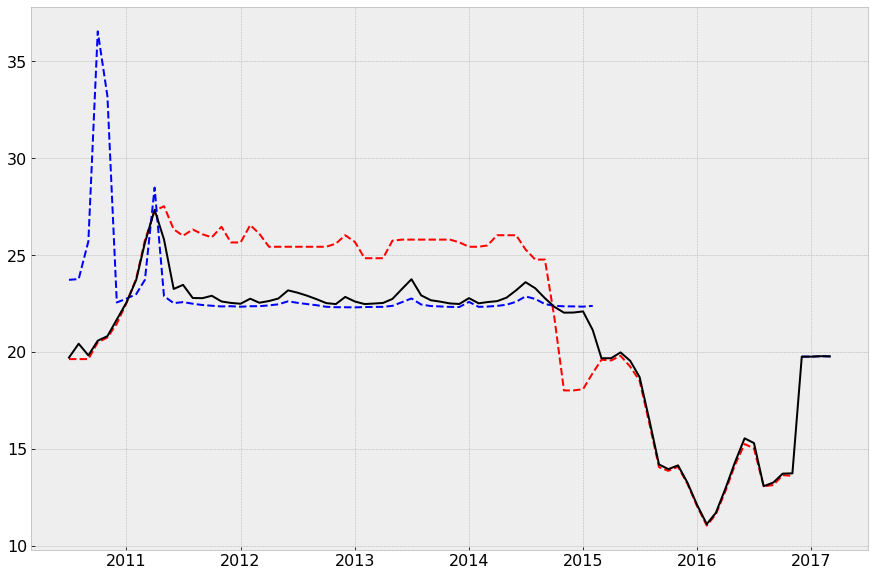

In [122]:
color_list = ['r', 'b', 'g']

i = 0 
for col in unit_cost_cols:
    plt.plot(unit_cost_df[date_col], unit_cost_df[col], label=col, linestyle='--', color=color_list[i])
    i +=1
    
plt.plot(unit_cost_df[date_col], unit_cost_df[bldg_unit_cost_col], label=bldg_unit_cost_col, linestyle='-', color='k')

plt.show()

# Need to get different data-- it appears that the dollars per mmbtu graphed are global costs, not building costs

# Water Analysis Table - Page 10

In [123]:
water_use = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo','cost', 'usage', 'units']]
water_use

,service_type,fiscal_year,fiscal_mo,cost,usage,units
27864,Electricity,2011,1,3055.367586,68139.310345,kWh
27865,Electricity,2011,1,0.000000,158.627586,kW
27866,Electricity,2011,1,1487.082414,0.000000,-
27867,Electricity,2011,1,6597.433966,NaN,-
27868,Electricity,2011,2,5569.483929,124207.962382,kWh
27869,Electricity,2011,2,0.000000,293.287565,kW
27870,Electricity,2011,2,2738.538647,0.000000,-
27871,Electricity,2011,2,11848.208004,NaN,-
27872,Electricity,2011,3,5294.718140,118080.313480,kWh
27873,Electricity,2011,3,0.000000,307.093469,kW


In [124]:
# Create annual water gallon usage dataframe
water_gal_df = pd.pivot_table(water_use, 
                              values='usage',
                              index=['fiscal_year',], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_gal_df.head()

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water
fiscal_year,,,,,
2011,1.312100e+06,8912.400000,46248.529412,1.921889e+06,1.921889e+06
2012,1.326766e+06,71657.535484,4950.321977,1.868884e+06,1.868884e+06
2013,1.398488e+06,75963.155425,5914.305263,1.850520e+06,1.850520e+06
2014,1.370306e+06,71968.425220,4534.906411,1.865012e+06,1.865012e+06
2015,1.274997e+06,42431.483871,18297.436937,1.744529e+06,1.744529e+06


In [125]:
# Use only required columns 
water_gal_df = water_gal_df[['Water']]
# Calculate percent change column
water_gal_df['water_use_pct_change'] = water_gal_df.Water.pct_change()

In [126]:
# Create annual water and sewer cost dataframe
water_cost_df = pd.pivot_table(water_use, 
                              values='cost',
                              index=['fiscal_year',], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_cost_df.head()

service_type,Electricity,Natural Gas,Oil #1,Sewer,Water
fiscal_year,,,,,
2011,219417.920484,20902.767000,139185.262647,20574.345714,18691.966786
2012,259963.550297,163613.406387,17351.334533,23036.310714,20921.145357
2013,275139.732445,173104.449037,20369.326596,19855.745738,19746.999190
2014,251432.023962,164359.650963,15747.134827,20014.054124,19390.952860
2015,227141.199531,97125.406774,48709.171396,19329.089516,18718.094839


In [127]:
# Calculate totals, percent change
water_cost_df = water_cost_df[['Sewer', 'Water']]
water_cost_df = water_cost_df.rename(columns={'Sewer': 'Sewer Cost',
                                             'Water': 'Water Cost'})
water_cost_df['total_water_sewer_cost'] = water_cost_df['Sewer Cost'] + water_cost_df['Water Cost']
water_cost_df['water_cost_pct_change'] = water_cost_df['Water Cost'].pct_change()
water_cost_df['sewer_cost_pct_change'] = water_cost_df['Sewer Cost'].pct_change()
water_cost_df['total_water_sewer_cost_pct_change'] = water_cost_df.total_water_sewer_cost.pct_change()

In [128]:
# Merge use and cost dataframes
water_use_and_cost = pd.merge(water_cost_df, water_gal_df, left_index=True, right_index=True, how='outer')
water_use_and_cost.head()

service_type,Sewer Cost,Water Cost,total_water_sewer_cost,water_cost_pct_change,sewer_cost_pct_change,total_water_sewer_cost_pct_change,Water,water_use_pct_change
fiscal_year,,,,,,,,
2011,20574.345714,18691.966786,39266.312500,NaN,NaN,NaN,1.921889e+06,NaN
2012,23036.310714,20921.145357,43957.456071,0.119259,0.119662,0.119470,1.868884e+06,-0.027580
2013,19855.745738,19746.999190,39602.744929,-0.056122,-0.138067,-0.099066,1.850520e+06,-0.009826
2014,20014.054124,19390.952860,39405.006984,-0.018030,0.007973,-0.004993,1.865012e+06,0.007831
2015,19329.089516,18718.094839,38047.184355,-0.034700,-0.034224,-0.034458,1.744529e+06,-0.064601


In [129]:
water_use_and_cost['water_unit_cost'] = water_use_and_cost.total_water_sewer_cost / water_use_and_cost.Water
water_use_and_cost['water_unit_cost_pct_change'] = water_use_and_cost.water_unit_cost.pct_change()
water_use_and_cost.head()

service_type,Sewer Cost,Water Cost,total_water_sewer_cost,water_cost_pct_change,sewer_cost_pct_change,total_water_sewer_cost_pct_change,Water,water_use_pct_change,water_unit_cost,water_unit_cost_pct_change
fiscal_year,,,,,,,,,,
2011,20574.345714,18691.966786,39266.312500,NaN,NaN,NaN,1.921889e+06,NaN,0.020431,NaN
2012,23036.310714,20921.145357,43957.456071,0.119259,0.119662,0.119470,1.868884e+06,-0.027580,0.023521,0.151221
2013,19855.745738,19746.999190,39602.744929,-0.056122,-0.138067,-0.099066,1.850520e+06,-0.009826,0.021401,-0.090126
2014,20014.054124,19390.952860,39405.006984,-0.018030,0.007973,-0.004993,1.865012e+06,0.007831,0.021129,-0.012724
2015,19329.089516,18718.094839,38047.184355,-0.034700,-0.034224,-0.034458,1.744529e+06,-0.064601,0.021809,0.032225


## Create Water Cost Stacked Bar Graph - Page 10 Graph 1

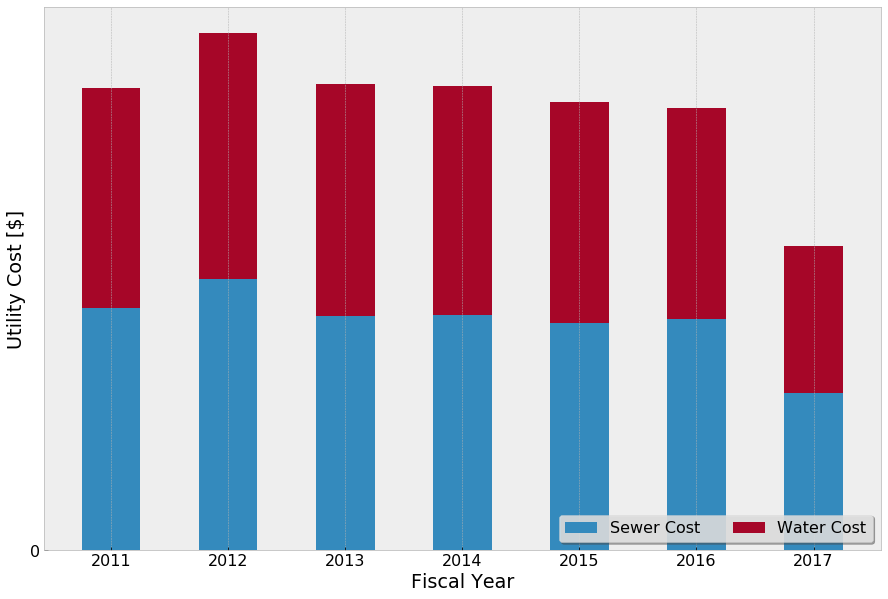

In [130]:
water_stack_filename = site + "_graph_pg10_g1.png"
gu.create_stacked_bar(water_use_and_cost.reset_index(), 'fiscal_year', ['Sewer Cost', 'Water Cost'], 
                      'Utility Cost [$]', water_stack_filename)

## Create Monthly Profile of Water Usage - Page 10 Graph 2

In [131]:
# Create monthly water gallon dataframe
water_gal_df_monthly = pd.pivot_table(water_use, 
                              values='usage',
                              index=['fiscal_year', 'fiscal_mo'], 
                              columns=['service_type'],
                              aggfunc=np.sum
)

water_gal_df_monthly.head()

service_type             Electricity  Natural Gas       Oil #1          Sewer  \
fiscal_year fiscal_mo                                                           
2011        1           68297.937931    19.161290   731.395349            NaN   
            2          124501.249948   384.967742  1224.512059  178837.142857   
            3          118387.406949   160.595106  3754.592593  124089.642857   
            4          127190.808621    42.135237  5784.583333  133660.714286   
            5          113981.851239    48.761315  6662.888889  190733.928571   

service_type                   Water  
fiscal_year fiscal_mo                 
2011        1                    NaN  
            2          178837.142857  
            3          124089.642857  
            4          133660.714286  
            5          190733.928571

In [132]:
# Only send records for full years to graphing function
merged_water_gal = pd.merge(water_gal_df_monthly.reset_index(), mo_count_df, left_on='fiscal_year', 
                               right_index=True, how='left')
full_year_water_gal = merged_water_gal.query("month == 12")
full_year_water_gal = full_year_water_gal.set_index(['fiscal_year','fiscal_mo'])
full_year_water_gal.head()

Electricity  Natural Gas       Oil #1          Sewer  \
fiscal_year fiscal_mo                                                           
2011        1           68297.937931    19.161290   731.395349            NaN   
            2          124501.249948   384.967742  1224.512059  178837.142857   
            3          118387.406949   160.595106  3754.592593  124089.642857   
            4          127190.808621    42.135237  5784.583333  133660.714286   
            5          113981.851239    48.761315  6662.888889  190733.928571   

                               Water  month  
fiscal_year fiscal_mo                        
2011        1                    NaN     12  
            2          178837.142857     12  
            3          124089.642857     12  
            4          133660.714286     12  
            5          190733.928571     12

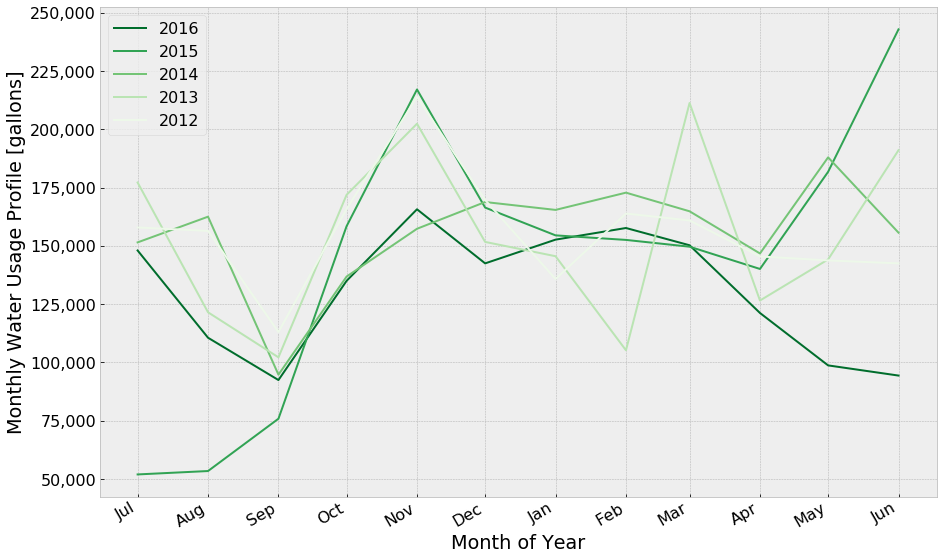

In [133]:
filename = site + "_graph_pg10_g2.png"
gu.create_monthly_profile(full_year_water_gal, 'Water', 'Monthly Water Usage Profile [gallons]', 'green', filename)